In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy  # CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters
# learning_rate = 1.0e-3
conv_dim = 16
rnn_dim = 16
pool_size = 2
pool_stride = 2
l2_regu = 0.001
drop_rate = 0.2
hidden_units = 256
fcn_dim = 256

# learning_rate = 1.e-4
# conv_dim = 64
# rnn_dim = 16
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.00
# drop_rate = 0.2
# # drop_rate = 0.5
# hidden_units = 512
# fcn_dim = 512

num_epoch = 200
# batch_size = 128
# batch_size = 32  # for cnn14+attention
batch_size = 16  # for cnn14+spp

num_patience = 20

In [4]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [5]:
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
num_species = len(species_dict)
# species_dict = {'BD': 0, 'MH': 1, 'CD': 2, 'STR': 3, 'SPT': 4, 'SPIN': 5, 'PLT': 6, 'RD': 7, 'RT': 8,
#                 'WSD': 9, 'FKW': 10, 'BEL': 11, 'KW': 12, 'WBD': 13, 'DUSK': 14, 'FRA': 15, 'PKW': 16, 'LPLT': 17,
#                 'CLY': 18, 'SPE': 19, 'ASP': 20}
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

## Combine features

In [6]:
deployment = ['STAR2000', 'STAR2003', 'STAR2006', 'HICEAS2002', 'PICEAS2005']  # oswald_STAR2000_orig.npz, oswald_STAR2000_aug.npz
feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210223_augment_all_three_noise_mixed'
# feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210308_augment_all_three_noise_mixed_class_balanced_min_5'


In [7]:
if False:
    for ee in deployment:
        print(ee)
        ee_others = [ee2 for ee2 in deployment if (ee2 != ee) ]
        fea_train_files_tot = []
        for ee2 in ee_others:
            fea_train_files_tot.append('oswald_'+ee2+'_orig.npz')
            fea_train_files_tot.append('oswald_'+ee2+'_aug.npz')

        # Training data
        fea_train_list = []
        label_train_list = []
        for ii in range(len(fea_train_files_tot)):
            ff = fea_train_files_tot[ii]
            print(ff)
            fea_temp = np.load(os.path.join(feature_path, ff))
            print(fea_temp.files)

            if ii == 0:
                fea_train = fea_temp['feas_orig']
                label_train = fea_temp['labels_orig']
                print(fea_train.shape)
                print(label_train.shape)
            elif ii % 2 == 0:  # even
                fea_train = np.concatenate([fea_train, fea_temp['feas_orig']])
                label_train = np.concatenate([label_train, fea_temp['labels_orig']])
                print(fea_train.shape)
                print(label_train.shape)
            else:
                fea_train = np.concatenate([fea_train, fea_temp['feas_aug']])
                label_train = np.concatenate([label_train, fea_temp['labels_aug']])
                print(fea_train.shape)
                print(label_train.shape)
        print(fea_train.shape)
        print(label_train.shape)
        np.savez(os.path.join(feature_path, './train_oswald_no_'+ee+'.npz'), fea_train=fea_train, label_train=label_train)
        print('')

In [8]:
# data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, feature, label, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.X = feature
        self.X_dim = len(feature.shape)
        self.y = to_categorical(label, num_classes)
        self.indices = np.arange(self.y.shape[0])
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # self.index = np.arange(len(self.indices))
        #self.df = dataframe
        #self.indices = self.df.index.tolist()        
        # self.x_col = x_col
        # self.y_col = y_col
        
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.indices)/self.batch_size))
        # return label.shape[0]

    def __getitem__(self, index):
        # index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.indices[k] for k in index]
        batch = list(range(index*self.batch_size, (index+1)*self.batch_size))
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        y = np.zeros((self.batch_size, self.y.shape[1]))
        
        if self.X_dim == 3:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2]))
            for i, id in enumerate(batch):
                X[i,:, :] = self.X[id, :, :]  # logic
                y[i, :] = self.y[id, :] # labels
                
        elif self.X_dim == 4:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2], self.X.shape[3]))
            for i, id in enumerate(batch):
                X[i,:, :, :] = self.X[id, :, :, :]  # logic
                y[i, :] = self.y[id, :] # labels

        return X, y

## Models

In [9]:
# Kong's attention
# def max_pooling(inputs, **kwargs):
#     input = inputs[0]   # (batch_size, time_steps, freq_bins)
#     return K.max(input, axis=1)
def max_pooling(inputs, **kwargs):
    # input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.max(inputs, axis=1)


def average_pooling(inputs, **kwargs):
    input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.mean(input, axis=1)


def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)


def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

In [10]:
from lib_validation import find_best_model

fit_result_path2 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210310_095616/STAR2000'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.1938
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210310_095616/STAR2000/epoch_48_valloss_0.1938_valacc_0.7403.hdf5


In [11]:
model = load_model(the_best_model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128, 16)      0     

In [12]:
# Training data
# fea_temp = np.load(os.path.join(feature_path, 'oswald_STAR2000_orig.npz'))
# fea_temp = np.load(os.path.join(feature_path, 'oswald_STAR2003_orig.npz'))
fea_temp = np.load(os.path.join(feature_path, 'oswald_STAR2006_orig.npz'))
# fea_temp = np.load(os.path.join(feature_path, 'oswald_HICEAS2002_orig.npz'))
# fea_temp = np.load(os.path.join(feature_path, 'oswald_PICEAS2005_orig.npz'))
    
fea_train = fea_temp['feas_orig']
label_train_list = fea_temp['labels_orig']
del fea_temp

fea_train = fea_train[:,:100,:]
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [13]:
# testing the training data
label_train_pred = model.predict(fea_train)

In [14]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [15]:
print("Confusion matrix:")
cm = confusion_matrix(label_train[:label_train_pred.shape[0]], np.argmax(label_train_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  0   0   0   0   0   0   0   0]
 [  0  19   4   0   0   1   0   0]
 [  0   5 741   4   0   0   0   0]
 [  0   0   8 139   0   0   0   0]
 [  0   0   0   1   1   0   0   0]
 [  1  11  26  22   0 548   5  19]
 [  1   0   4   4   0   6  29   2]
 [  0   0  14   0   0   3   4 882]]

[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.79 0.17 0.   0.   0.04 0.   0.  ]
 [0.   0.01 0.99 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.05 0.95 0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  0.5  0.   0.   0.  ]
 [0.   0.02 0.04 0.03 0.   0.87 0.01 0.03]
 [0.02 0.   0.09 0.09 0.   0.13 0.63 0.04]
 [0.   0.   0.02 0.   0.   0.   0.   0.98]]


In [16]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

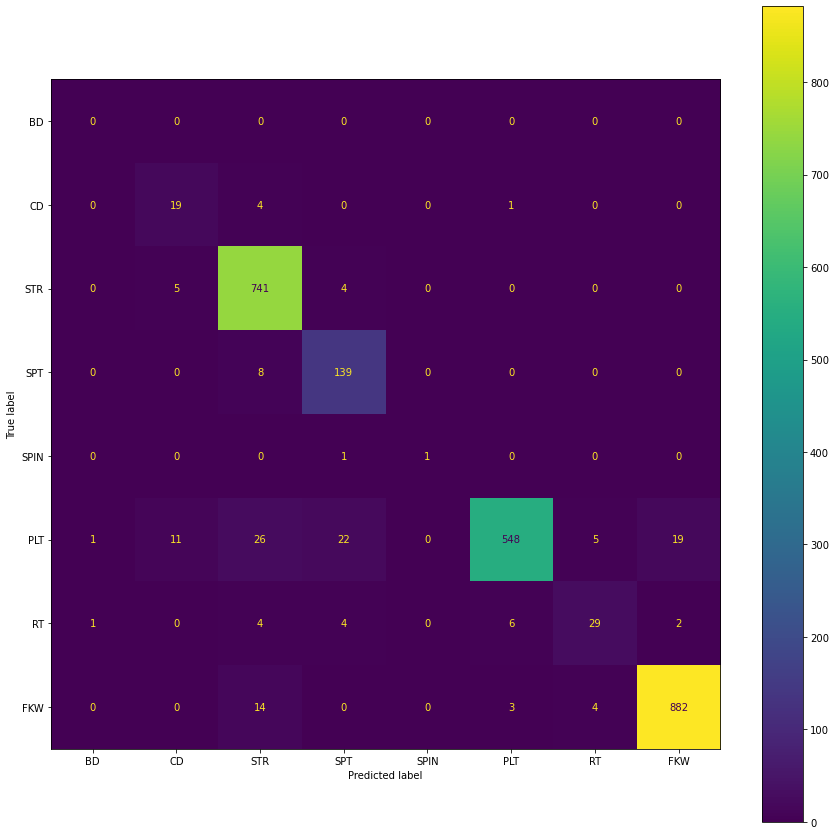

In [17]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


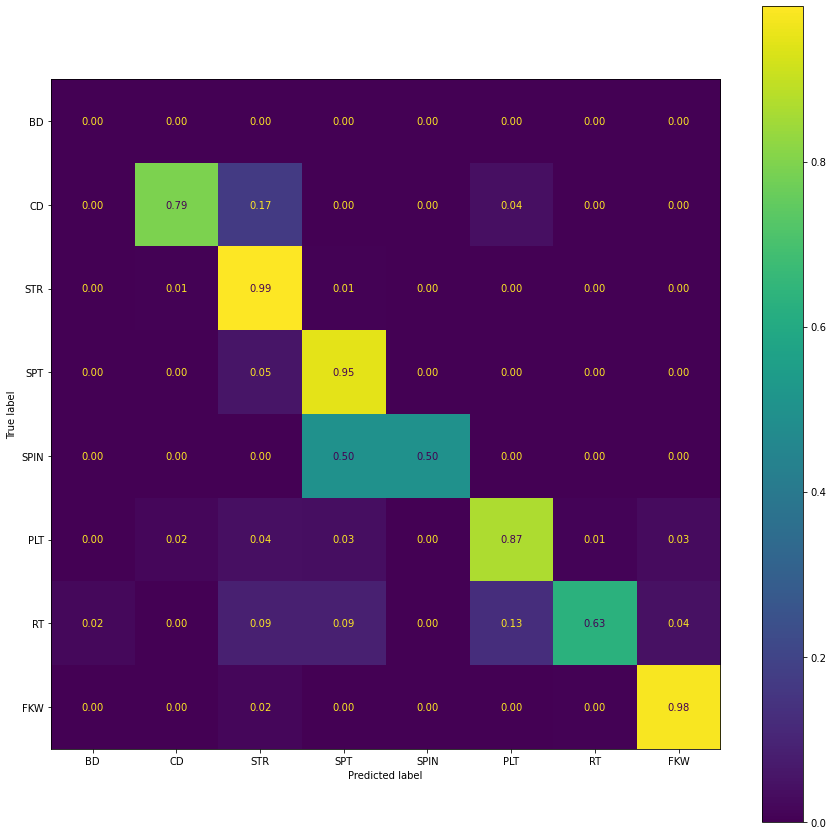

In [18]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## sound clips from an acoustic encounter

In [19]:
import pandas as pd

In [20]:
df_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210223_augment_all_three_noise_mixed/oswald_STAR2006.csv'

In [21]:
df_oswald = pd.read_csv(df_path)

In [22]:
df_oswald['filename']

0        CD_STAR2006_s216_18311.wav
1        CD_STAR2006_s216_18312.wav
2        CD_STAR2006_s216_18313.wav
3        CD_STAR2006_s216_18314.wav
4        CD_STAR2006_s216_18315.wav
                   ...             
2499    STR_STAR2006_s248_16502.wav
2500    STR_STAR2006_s248_16503.wav
2501    STR_STAR2006_s248_16504.wav
2502    STR_STAR2006_s248_16505.wav
2503    STR_STAR2006_s248_16506.wav
Name: filename, Length: 2504, dtype: object

In [23]:
df_oswald.columns

Index(['dataset', 'filename', 'species', 'id', 'deployment'], dtype='object')

In [26]:
# deploy_path_test = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/STAR2003_48kHz'
deploy_path_test = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/STAR2006_48kHz'
# deploy_path_test = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/HICEAS2002_48kHz'
# deploy_path_test = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/PICEAS2005_48kHz'

# deploy_path_test = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/STAR2000_48kHz'
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
fs = 48000
time_reso = 0.02
hop_length = int(time_reso*fs)  #

step_sec = 0.5
# step_size = int(1.0*fs)
step_size = int(step_sec*fs)
win_size = int(2.0*fs)

In [27]:
encounter_test =  os.listdir(deploy_path_test)
encounter_test.sort()

In [28]:
encounter_test

['false_killer s128',
 'pilot s142',
 'pilot s144',
 'pilot s145',
 'pilot s154',
 'pilot s156',
 'pilot s223',
 'pilot s230',
 'roughtoothed s112',
 'roughtoothed s153',
 'shortbeaked_common s216',
 'spinner s110',
 'spotted s237',
 'striped s111',
 'striped s115',
 'striped s138',
 'striped s205',
 'striped s248']

In [38]:
df_curr = df_oswald[df_oswald['filename'].apply(lambda x: 's156'  in x)]

In [39]:
df_curr

,dataset,filename,species,id,deployment
1206,oswald,PLT_STAR2006_s156_16507.wav,PLT,16507,STAR2006
1207,oswald,PLT_STAR2006_s156_16508.wav,PLT,16508,STAR2006
1208,oswald,PLT_STAR2006_s156_16509.wav,PLT,16509,STAR2006
1209,oswald,PLT_STAR2006_s156_16510.wav,PLT,16510,STAR2006


In [40]:
# test the training clips

In [41]:
sound_path='/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/__oswald/__sound_clips'

In [42]:
import os
import librosa
from lib_augment import load_and_normalize
from lib_feature import feature_whistleness

fs=48000
hop_length=960
spec_feas = []
for index, row in df_curr.iterrows():
    samples = load_and_normalize(os.path.join(sound_path, row['filename']), sr=fs)
    spectro = librosa.feature.melspectrogram(samples, sr=fs, hop_length=hop_length, power=1.0)
    spec_feas.append(feature_whistleness(spectro))


In [43]:
spec_feas0 = np.stack(spec_feas)

In [44]:
spec_feas0 = np.expand_dims(spec_feas0[:, :100, :], axis=3)

In [45]:
label_train_clip_pred = model.predict(spec_feas0)

In [46]:
label_train_clip_pred

array([[0.  , 0.  , 0.01, 0.03, 0.  , 0.88, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.94, 0.  , 0.21, 0.  , 0.  ],
       [0.02, 0.  , 0.01, 0.31, 0.  , 0.75, 0.01, 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]], dtype=float32)

### 